In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.1 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge,ob):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons\
                                       ,active_orbitals=ob)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.00001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited states with Sz = 0
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if np.abs(Sz) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=0:',eng[i]-0.00001*Sz)

            E_collect.append(eng[i]-0.00001*Sz)
            k+=1
        if k==2:
            break
    return E_collect


We use exact diagonalization to get the corresponding ground state and first excited state.

In [5]:
O_dict={}
r_lst=[0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6,4.0]
ob_lst=[2,3,4,5,6]
for ob in ob_lst:
    E0_lst=[]
    E1_lst=[]
    E2_lst=[]
    for r in r_lst:
        #orbital_num=3
        a0=0.529177210903
        #L=1.7/a0                    # Convert unit from Bohr to atomic unit
        #r=1.7
        symbol=["H", "Li"]        # HLi
        geometry=np.array([0.0, 0.0, -r/a0/2, 0.0, 0.0, r/a0/2])

        charge=0
        num_electrons=2
        if ob==6:
            num_electrons=4
        E0,E1,E2=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge,ob)
        E0_lst.append(E0)
        E1_lst.append(E1)
        E2_lst.append(E2)
    O_dict[ob]=[E0_lst,E1_lst,E2_lst]

The ground state energy with sz=0: -6.615749722849902
The first excied state energy with sz=0: (-6.5988571326040875+0j)
The first excied state energy with sz=0: (-6.566196386414652+0j)
The ground state energy with sz=0: -7.615915762587774
The first excied state energy with sz=0: (-7.496281855304364+0j)
The first excied state energy with sz=0: (-7.481142706658846+0j)
The ground state energy with sz=0: -7.835766811445799
The first excied state energy with sz=0: (-7.680866385768533+0j)
The first excied state energy with sz=0: (-7.66774593432455+0j)
The ground state energy with sz=0: -7.862128847849031
The first excied state energy with sz=0: (-7.721987520634189+0j)
The first excied state energy with sz=0: (-7.7077026003424285+0j)
The ground state energy with sz=0: -7.8315336507443405
The first excied state energy with sz=0: (-7.722355382504767+0j)
The first excied state energy with sz=0: (-7.704470300130868+0j)
The ground state energy with sz=0: -7.7853136546703
The first excied state ene

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


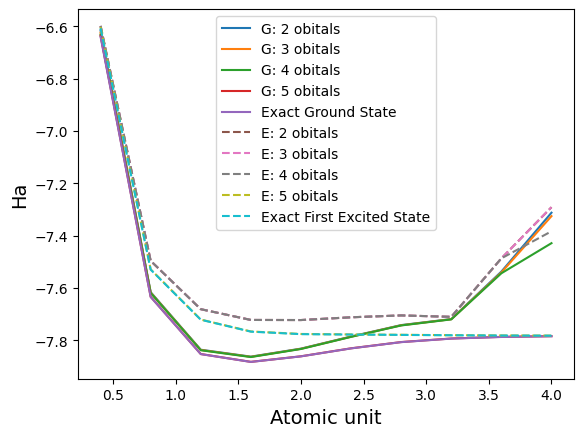

In [6]:
r_lst=[0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6,4.0]
ob_lst=[2,3,4,5,6]
for ob in ob_lst:
    if ob==6:
        plt.plot(r_lst,O_dict[ob][0],label='Exact Ground State')
    else:
        plt.plot(r_lst,O_dict[ob][0],label='G: '+str(ob)+' obitals')

for ob in ob_lst:
    if ob==6:
        plt.plot(r_lst,O_dict[ob][1],'--',label='Exact First Excited State')
    else:
        plt.plot(r_lst,O_dict[ob][1],'--',label='E: '+str(ob)+' obitals')
    #plt.plot(r_lst,O_dict[ob][2],':',label='S E'+str(ob))
plt.xlabel('Atomic unit',fontsize=14)
plt.ylabel('Ha',fontsize=14)
plt.legend()

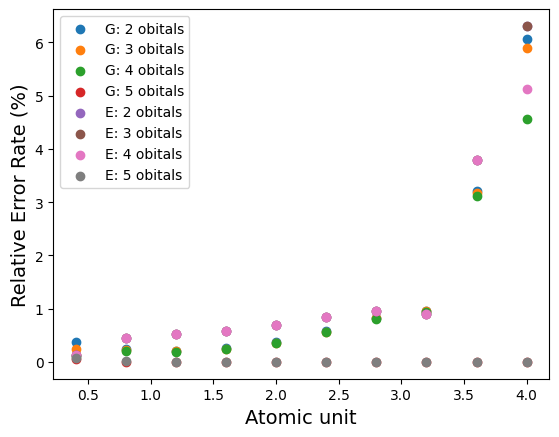

In [7]:
r_lst=[0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6,4.0]
ob_lst=[2,3,4,5]
for ob in ob_lst:
    Rel_e=np.abs(np.array(O_dict[ob][0])-np.array(O_dict[6][0]))*100/np.abs(O_dict[6][0])
    plt.scatter(r_lst,Rel_e,label='G: '+str(ob)+' obitals')

for ob in ob_lst:
    Rel_e=np.abs(np.array(O_dict[ob][1])-np.array(O_dict[6][1]))*100/np.abs(O_dict[6][1])
    plt.scatter(r_lst,Rel_e,label='E: '+str(ob)+' obitals')
    #plt.plot(r_lst,O_dict[ob][2],':',label='S E'+str(ob))
plt.xlabel('Atomic unit',fontsize=14)
plt.ylabel('Relative Error Rate (%)',fontsize=14)
plt.legend()

In [12]:
f = open("Num_Orbs_LiH","wb")
pickle.dump(O_dict,f)

In [13]:
file = open("Num_Orbs_LiH",'rb')
ob_dict = pickle.load(file)